# **Wiktor Ciołek LSED lab2 27.03.2024**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal as mvnorm

plt.rcParams['font.size'] = 18

# Data generated

In [21]:
mu1 = np.array([-3, 1])
mu2 = np.array([2, 2])
sd1 = np.array([[4., 0], [0, 4.]])
n1, n2 =  40, 30

X1 = np.random.multivariate_normal(mu1, sd1, n1)
X2 = np.random.multivariate_normal(mu2, sd1, n2)

data = np.concatenate((X1, X2), axis = 0)
data = pd.DataFrame(data, columns=["x", "y"])

data["class"] = np.repeat([0, 1], [n1, n2])
data.sample(6)

,x,y,class
5,-4.089786,1.069177,0
19,-2.939758,3.576413,0
40,1.565504,3.545344,1
20,-2.874264,2.283132,0
66,4.297230,2.825979,1
12,-4.951870,-0.981489,0


# Data visualized

c:\Users\cp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

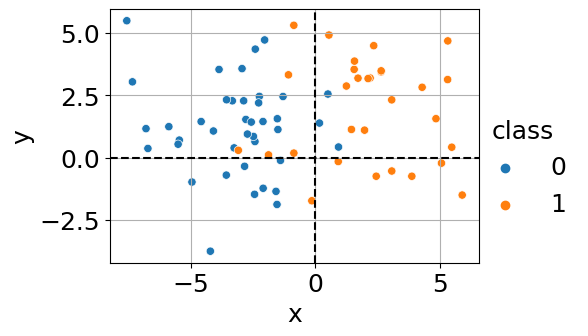

In [22]:
g = sns.relplot(data, x='x', y='y', hue='class')
g.ax.spines['top'].set_visible(True)
g.ax.spines['right'].set_visible(True)
g.ax.set_aspect('equal')
plt.axvline(0, linestyle='--', color='black')
plt.axhline(0, linestyle='--', color='black')
plt.grid()

# Data described

In [23]:
S1 = np.cov(X1, rowvar=False)
S2 = np.cov(X2, rowvar=False)
print("COVARIANCE MATRIXES")
print("Class 0")
print(S1)
print("Class 1")
print(S2)
S = np.array([S1, S2])

Mu1 = np.average(X1, axis = 0)
Mu2 = np.average(X2, axis = 0)
print("\nMEANS")
print("Class 0")
print(Mu1)
print("Class 1")
print(Mu2)

COVARIANCE MATRIXES
Class 0
[[ 3.99663136 -0.40250149]
 [-0.40250149  3.45847064]]
Class 1
[[ 5.33743324 -0.21231961]
 [-0.21231961  4.24805017]]

MEANS
Class 0
[-3.12772052  1.19377496]
Class 1
[2.12952245 1.89961978]


# Own Naive Bayes Class

In [24]:
class Own_NB():
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y, num_bins=10):
        """
        X - learning set of observations with shape (n, d)
        n - number of observation
        d - dimension
        y - class labels
        bins - resolution of space density
        """
        self.bins = num_bins
        self.classes = np.unique(y)
        num_feature = X.shape[1]
        num_class = len(self.classes)
        X['class'] = y
        
        freqs = X.groupby('class').count() / len(X)
        self.Pi = freqs['x']

        self.S = X.groupby('class').cov()
        self.mu = X.groupby('class').mean()

        # levels case (categorization??)
        # self.X_min, self.X_max = X.groupby('class').min(), X.groupby('class').min()
        # self.bin_width = (self.X_max - self.X_min) / self.bins

        # self.obs_density = np.zeros((num_class, num_feature, num_bins))
        # for k in range(num_class):
        #     for i in range(num_feature): 
        #         hist, _ = np.histogramdd(X[X['class'] == self.classes[k]].iloc[:, i], bins=num_bins, range=(self.X_min.iloc[k, i], self.X_max.iloc[k, i]))
        #         self.obs_density[k, i] = hist
        

    def predict_class(self, X):
        """
        X - new observation
        # Returns:
        indexes of predicted classes
        """
        # bin_index = int((X - self.X_min) / self.bin_width)
        # if bin_index < 0 or bin_index >= len(density):
        #     return 0

        probs = np.zeros((len(X), len(self.classes)))
        p_cond = np.zeros((len(X), len(self.classes)))
        for k in range(len(self.classes)):
            p_cond[:, k] = mvnorm.pdf(X, self.mu.loc[k], np.sqrt(self.S.loc[k]))

        for k in range(len(self.classes)):
            probs[:, k] = self.Pi[k] * p_cond[:, k] 

        for i in range(len(X)): 
            probs[i] /= self.Pi @ p_cond[i]
        best_class = self.classes[np.argmax(probs, axis=0)]
        return int(best_class)


    def predict_proba(self, X):
        """
        X - new observation
        # Returns:
        array of probabilities of lenght k, where k is number of classes
        """
        # bin_index = int((X - self.X_min) / self.bin_width)
        # if bin_index < 0 or bin_index >= len(density):
        #     return 0
         
        probs = np.zeros((len(X), len(self.classes)))
        p_cond = np.zeros((len(X), len(self.classes)))
        for k in range(len(self.classes)):
            p_cond[:, k] = mvnorm.pdf(X, self.mu.loc[k], self.S.loc[k])

        for k in range(len(self.classes)):
            probs[:, k] = self.Pi[k] * p_cond[:, k] 

        for i in range(len(X)): 
            probs[i] /= self.Pi @ p_cond[i]
        return probs      

# Own Naive Bayes decision boundary

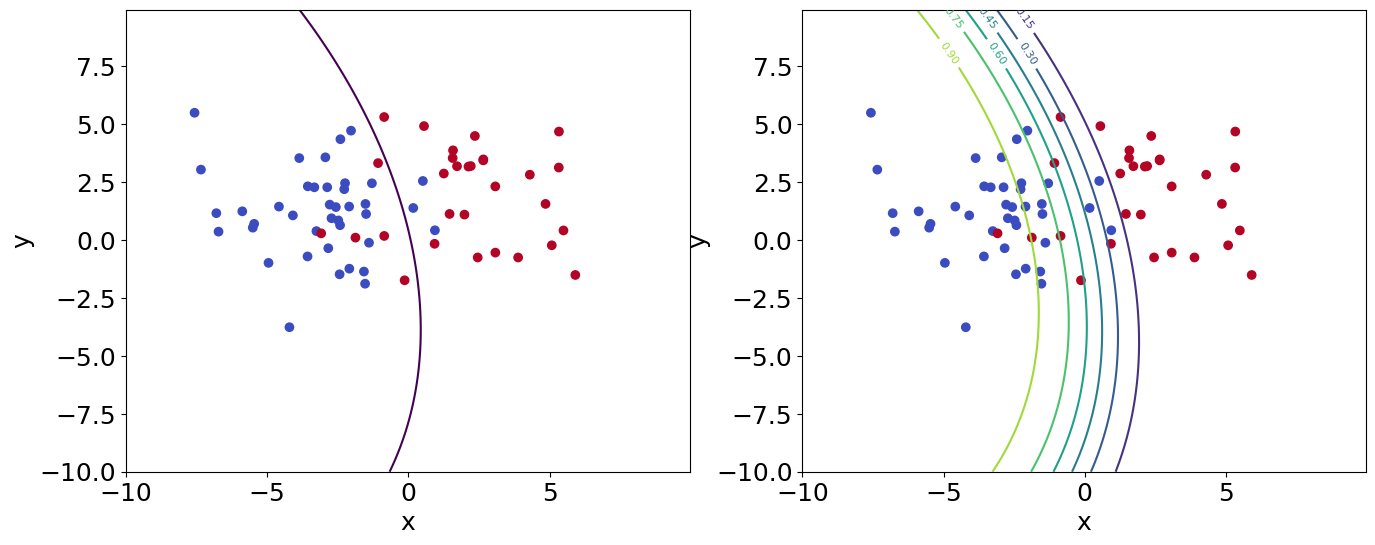

In [25]:
own_nb = Own_NB()
own_nb.fit(data[['x', 'y']], data['class'])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

x, y = np.mgrid[-10:10:.05, -10:10:.05]
data_grid = pd.DataFrame({'x': x.ravel(), 'y': y.ravel()})
Z = own_nb.predict_proba(data_grid)[:,0].reshape(x.shape)

ax[0].contour(x, y, Z, [0.5])
contours = ax[1].contour(x, y, Z, 6)

plt.clabel(contours, inline=True, fontsize=8)

for ax in ax:
    ax.scatter(data=data, x='x', y='y', c='class', cmap=plt.cm.coolwarm)
    ax.set_ylabel('y')
    ax.set_xlabel('x')
plt.show()

# *scikit.inspection.DecisionBoundaryDisplay* and *scikit.naive_bayes.GaussianNB* result

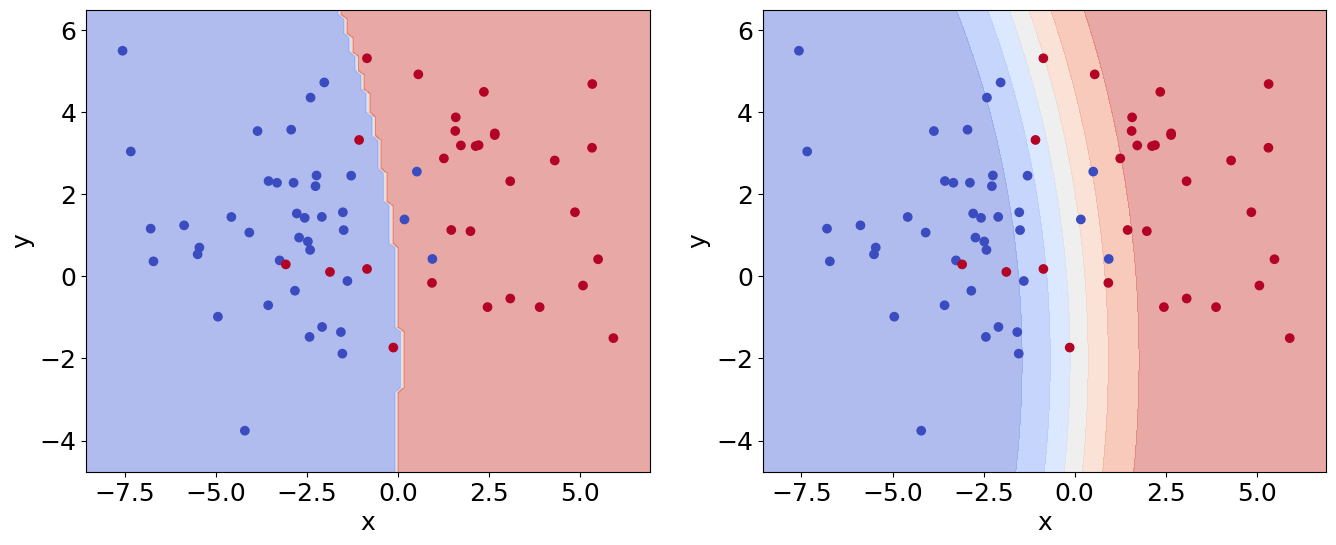

In [26]:
nb = GaussianNB()
nb.fit(X=data[['x','y']], y=data['class'])

fig, ax = plt.subplots(1, 2, figsize=(16,6))
DecisionBoundaryDisplay.from_estimator(nb, data[['x', 'y']], response_method='predict', alpha=0.45, cmap=plt.cm.coolwarm, ax=ax[0])
ax[0].scatter(data=data, x='x', y='y', c='class', cmap=plt.cm.coolwarm)

d2 = DecisionBoundaryDisplay.from_estimator(nb, data[['x', 'y']], response_method='predict_proba', alpha=0.45, cmap=plt.cm.coolwarm, ax=ax[1])
ax[1].scatter(data=data, x='x', y='y', c='class', cmap=plt.cm.coolwarm)